In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm
import os


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stocks = ['9064', '9061', '9265']

In [3]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        try:
            scores.append(np.mean(row[column]))
        except:
            scores.append(np.mean(np.array(literal_eval(row[column])).astype(np.float64)))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

In [4]:
dfs = {}
dfs_test = {}
dfs_reg = {}
dfs_reg_test = {}
data_dir='../gaussian_filter/data_gdf_feature_scaling'
for stock in stocks:
    r = 0.1
    s = 1.0
    gdf_filename = 'gdf_{}_r{}_s{}_K50_feature_scaling'.format(stock, r, s)
    reg_filename = '{}'.format(stock)
    print(gdf_filename)
    dfs[stock], dfs_test[stock] = lob.load_prepared_data(
        gdf_filename, data_dir=data_dir, cv=False, length=data_length)
    dfs_reg[stock], dfs_reg_test[stock] = lob.load_prepared_data(
        reg_filename, data_dir='../gaussian_filter/data', cv=False, length=data_length)

gdf_9064_r0.1_s1.0_K50_feature_scaling
gdf_9061_r0.1_s1.0_K50_feature_scaling
gdf_9265_r0.1_s1.0_K50_feature_scaling


In [5]:
df = dfs[stock]
feature_columns = ['gdf_24', 'gdf_25']
res = {}
for C in [1, 10, 100, 1000, 1100]:
    for g in [0.1, 1, 2, 5]:
        clf = SVC(kernel='rbf', C=C, gamma=g)
        scores = model.validate_model(clf, df[feature_columns], df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res['C{}-g{}'.format(C, g)] = np.mean(df_score['matthews'].values)
res

{'C1-g0.1': 0.0,
 'C1-g1': 0.0011771955903456088,
 'C1-g2': -0.00165303944474691,
 'C1-g5': -0.0008694946948564187,
 'C10-g0.1': 0.00202168120978506,
 'C10-g1': -0.0016306655395214491,
 'C10-g2': -0.007469156880724034,
 'C10-g5': -0.000358317902982519,
 'C100-g0.1': -0.002044358259377207,
 'C100-g1': 0.0018276706333439185,
 'C100-g2': -0.00029005993233358643,
 'C100-g5': -0.003269692803653707,
 'C1000-g0.1': -0.0016306655395214491,
 'C1000-g1': 0.0008137926441224574,
 'C1000-g2': 0.0006876383233838818,
 'C1000-g5': 0.00776412447348731,
 'C1100-g0.1': -0.0016306655395214491,
 'C1100-g1': 0.001457587010635281,
 'C1100-g2': 0.00499500473756915,
 'C1100-g5': 0.008667947048966994}

In [6]:
df = dfs[stock]
feature_columns = ['gdf_16', 'gdf_33']
res = {}
for C in [1000, 1100, 1500, 10000]:
    for g in [0.20, 0.25, 0.30]:
        clf = SVC(kernel='rbf', C=1000, gamma=g)
        scores = model.validate_model(clf, df[feature_columns], df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res['C{}-g{}'.format(C, g)] = np.mean(df_score['matthews'].values)
res

{'C1000-g0.2': -0.0012516446958355703,
 'C1000-g0.25': -0.005915609560128811,
 'C1000-g0.3': -0.004516176675457573,
 'C1100-g0.2': -0.0012516446958355703,
 'C1100-g0.25': -0.005915609560128811,
 'C1100-g0.3': -0.004516176675457573,
 'C1500-g0.2': -0.0012516446958355703,
 'C1500-g0.25': -0.005915609560128811,
 'C1500-g0.3': -0.004516176675457573,
 'C10000-g0.2': -0.0012516446958355703,
 'C10000-g0.25': -0.005915609560128811,
 'C10000-g0.3': -0.004516176675457573}

['gdf_16', 'gdf_33', 'mid_price_indicator', 'gdf_24', 'gdf_25', 'gdf_26']


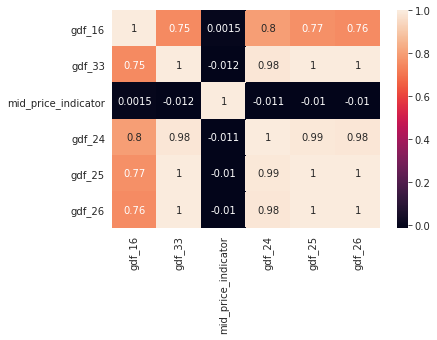

In [7]:
cols = feature_columns + ['mid_price_indicator'] + ['gdf_24', 'gdf_25', 'gdf_26']
print(cols)
sns.heatmap(df[cols].corr(), annot=True)

In [8]:
from sklearn.decomposition import PCA

X = df[[c for c in df.columns if 'gdf' in c]]
pca = PCA(n_components=3)
pca.fit(X)

X_transf = pca.transform(X)
res = {}
for C in [1000, 1100, 1500, 10000]:
    for g in [0.20, 0.25, 0.30]:
        clf = SVC(kernel='rbf', C=1000, gamma=g)
        scores = model.validate_model(clf, X_transf, df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res['C{}-g{}'.format(C, g)] = np.mean(df_score['matthews'].values)
res

{'C1000-g0.2': 0.00019167975314095793,
 'C1000-g0.25': -0.0003061384806787019,
 'C1000-g0.3': -0.0034526627051029734,
 'C1100-g0.2': 0.00019167975314095793,
 'C1100-g0.25': -0.0003061384806787019,
 'C1100-g0.3': -0.0034526627051029734,
 'C1500-g0.2': 0.00019167975314095793,
 'C1500-g0.25': -0.0003061384806787019,
 'C1500-g0.3': -0.0034526627051029734,
 'C10000-g0.2': 0.00019167975314095793,
 'C10000-g0.25': -0.0003061384806787019,
 'C10000-g0.3': -0.0034526627051029734}

In [9]:
dfs_reg[stock].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2000,2013-09-10 13:29:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3334.5, 1486.0), (3335.0, 1968.0), (3335.5, ...",3333.0,3334.5,3333.75,1486.0,1241.0,0.0,-0.089842
2001,2013-09-10 13:30:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3333.0, 452.0), (3333.5, 1060.0), (3334.0, 1...",3332.0,3333.0,3332.50,452.0,1518.0,1.0,0.541117
2002,2013-09-10 13:31:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3333.5, 562.0), (3334.0, 1088.0), (3334.5, 2...",3332.5,3333.5,3333.00,562.0,1061.0,0.0,0.307455
2003,2013-09-10 13:32:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3333.5, 1398.0), (3334.0, 1390.0), (3334.5, ...",3332.0,3333.5,3332.75,1398.0,540.0,1.0,-0.442724
2004,2013-09-10 13:33:00,"[(1980.0, 300.0), (2203.0, 240.0), (2440.0, 26...","[(3333.5, 870.0), (3334.0, 1372.0), (3334.5, 2...",3332.5,3333.5,3333.00,870.0,606.0,1.0,-0.178862


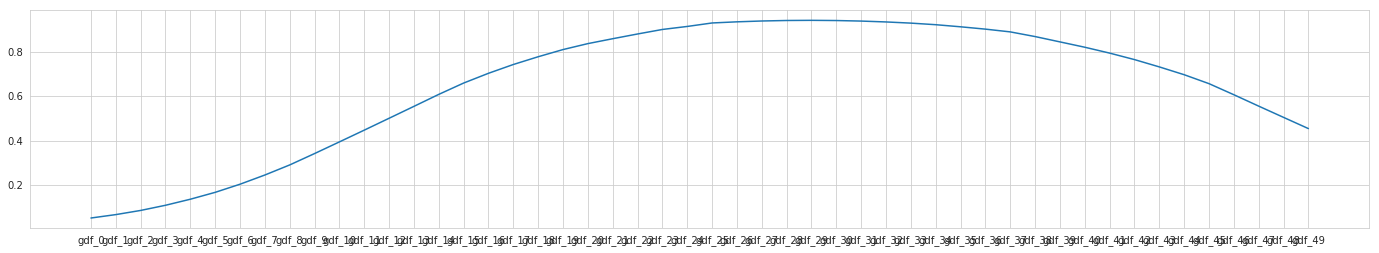

In [10]:
plt.figure(figsize=(24,4))
plt.plot(dfs[stock].iloc[2000][['gdf_{}'.format(i) for i in range(0, 50)]])


In [11]:
for stock in stocks:
    dfs[stock]['queue_imbalance'] = dfs_reg[stock]['queue_imbalance']
    dfs[stock]['prev_queue_imbalance'] = dfs[stock]['queue_imbalance'].shift()
    dfs[stock].dropna(inplace=True)
    dfs_test[stock]['queue_imbalance'] = dfs_reg_test[stock]['queue_imbalance']
    dfs_test[stock]['prev_queue_imbalance'] = dfs_test[stock]['queue_imbalance'].shift()
    dfs_test[stock].dropna(inplace=True)

['gdf_16', 'gdf_33', 'mid_price_indicator', 'gdf_24', 'gdf_25', 'gdf_26', 'queue_imbalance', 'prev_queue_imbalance']


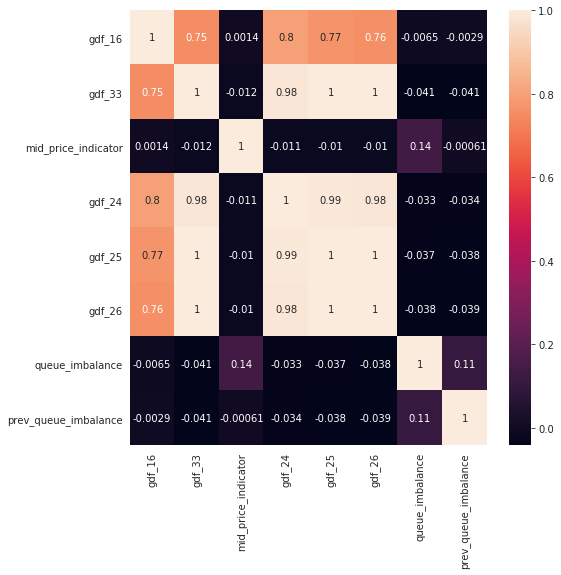

In [12]:
cols = feature_columns + ['mid_price_indicator'] + ['gdf_24', 'gdf_25', 'gdf_26'] + ['queue_imbalance', 'prev_queue_imbalance']
print(cols)
plt.figure(figsize=(8,8))
sns.heatmap(dfs[stock][cols].corr(), annot=True)

In [13]:
feature_columns_dict = {
    'gdf_24-26_que_prev': ['gdf_24', 'gdf_25', 'queue_imbalance', 'prev_queue_imbalance'], 
    'que': ['queue_imbalance'],
    'que_prev': ['queue_imbalance', 'prev_queue_imbalance'],
    'gdf_24-26_que': ['gdf_24', 'gdf_25', 'queue_imbalance'],
    'gdf_23-27_que': ['gdf_23', 'gdf_24', 'gdf_25', 'gdf_26', 'queue_imbalance'],
    'gdf_23-27': ['gdf_23', 'gdf_24', 'gdf_25', 'gdf_26'],
    'gdf_24_26': ['gdf_24', 'gdf_25'],
    'pca_gdf': ['gdf_{}'.format(i) for i in range(0, 50)],
    'pca_gdf_que': ['gdf_{}'.format(i) for i in range(0, 50)] + ['queue_imbalance'],
    'pca_gdf_que_prev': ['gdf_{}'.format(i) for i in range(0, 50)] + ['queue_imbalance', 'prev_queue_imbalance'],
    'gdf_20_30': ['gdf_{}'.format(i) for i in range(20, 30)],
    'gdf_20_30_que': ['gdf_{}'.format(i) for i in range(20, 30)] + ['queue_imbalance'],
    'gdf_20_30_que_prev': ['gdf_{}'.format(i) for i in range(20, 30)] + ['queue_imbalance', 'prev_queue_imbalance']
}
# res = []
# for stock in stocks:
#     df = dfs[stock]
#     df_test = dfs_test[stock]
#     print(stock)
#     for k, v in feature_columns_dict.items():
#         C = 1
#         gamma = 1
#         train_x = df[v]
#         if 'pca' in k:
#             X = df[v]
#             for i in range(2, 10):
#                 pca = PCA(n_components=i)
#                 pca.fit(X)
#                 train_x = pca.transform(X)
#                 clf = SVC(kernel='rbf', C=C, gamma=gamma)
#                 scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
#                 df_score = pd.DataFrame(scores)
#                 res.append({'matthews': np.mean(df_score['matthews'].values), 
#                         'stock': stock,
#                         'C': C,
#                         'gamma': gamma,
#                         'features': k + str(i)
#                        })
#                 continue
#         clf = SVC(kernel='rbf', C=C, gamma=gamma)
#         scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
#         #scores_test = model.test_model(clf, df_test[feature_columns], df_test['mid_price_indicator'])
#         df_score = pd.DataFrame(scores)
#         res.append({'matthews': np.mean(df_score['matthews'].values), 
#                     #'matthews_test': scores_test['test_matthews'],
#                     'stock': stock,
#                     'C': C,
#                     'gamma': gamma,
#                     'features': k
#                    })
# df_results = pd.DataFrame(res)
# df_results.sort_values(by='matthews', ascending=False).groupby('stock').head(5)

In [15]:
## let's train SVM!
stock = '9265'
df = dfs[stock]
res = []
for C in [0.1, 1, 10, 100, 1000]:
    for g in [0.1, 1, 10, 100, 1000]:
        clf = SVC(kernel='rbf', C=C, gamma=g)
        X = df[feature_columns_dict['pca_gdf_que']]
        pca = PCA(n_components=2)
        pca.fit(X)
        train_x = pca.transform(X)

        scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res.append({'matthews': np.mean(df_score['matthews'].values), 
                    'stock': stock,
                    'C': C,
                    'gamma': g,
                    'features': feature_columns
                   })
df_results_9265 = pd.DataFrame(res)

In [16]:
df_results_9265.sort_values(by='matthews', ascending=False)

,C,features,gamma,matthews,stock
6,1.0,"[gdf_16, gdf_33]",1.0,0.111929,9265
15,100.0,"[gdf_16, gdf_33]",0.1,0.110437,9265
1,0.1,"[gdf_16, gdf_33]",1.0,0.110413,9265
20,1000.0,"[gdf_16, gdf_33]",0.1,0.108387,9265
11,10.0,"[gdf_16, gdf_33]",1.0,0.107432,9265
7,1.0,"[gdf_16, gdf_33]",10.0,0.106426,9265
21,1000.0,"[gdf_16, gdf_33]",1.0,0.105110,9265
16,100.0,"[gdf_16, gdf_33]",1.0,0.104916,9265
10,10.0,"[gdf_16, gdf_33]",0.1,0.104738,9265
2,0.1,"[gdf_16, gdf_33]",10.0,0.101590,9265


In [17]:
## let's train SVM!
stock = '9061'
df = dfs[stock]
res = []
for C in [0.1, 1, 10, 100, 1000]:
    for g in [0.1, 1, 10, 100, 1000]:
        clf = SVC(kernel='rbf', C=C, gamma=g)
        X = df[feature_columns_dict['pca_gdf_que']]
        pca = PCA(n_components=8)
        pca.fit(X)
        train_x = pca.transform(X)

        scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res.append({'matthews': np.mean(df_score['matthews'].values), 
                    'stock': stock,
                    'C': C,
                    'gamma': g,
                    'features': feature_columns
                   })
df_results_9061 = pd.DataFrame(res)

In [18]:
df_results_9061.sort_values(by='matthews', ascending=False)

,C,features,gamma,matthews,stock
10,10.0,"[gdf_16, gdf_33]",0.1,0.101883,9061
6,1.0,"[gdf_16, gdf_33]",1.0,0.100276,9061
5,1.0,"[gdf_16, gdf_33]",0.1,0.099625,9061
15,100.0,"[gdf_16, gdf_33]",0.1,0.092241,9061
0,0.1,"[gdf_16, gdf_33]",0.1,0.086471,9061
1,0.1,"[gdf_16, gdf_33]",1.0,0.086237,9061
20,1000.0,"[gdf_16, gdf_33]",0.1,0.079708,9061
11,10.0,"[gdf_16, gdf_33]",1.0,0.079461,9061
2,0.1,"[gdf_16, gdf_33]",10.0,0.076050,9061
7,1.0,"[gdf_16, gdf_33]",10.0,0.075204,9061


In [19]:
stock = '9064'
df = dfs[stock]
res = []
for C in [0.1, 1, 10, 100, 1000]:
    for g in [0.1, 1, 10, 100, 1000]:
        clf = SVC(kernel='rbf', C=C, gamma=g)
        X = df[feature_columns_dict['pca_gdf_que']]
        pca = PCA(n_components=3)
        pca.fit(X)
        train_x = pca.transform(X)

        scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
        df_score = pd.DataFrame(scores)
        res.append({'matthews': np.mean(df_score['matthews'].values), 
                    'stock': stock,
                    'C': C,
                    'gamma': g,
                    'features': feature_columns
                   })
df_results_9064 = pd.DataFrame(res)

In [20]:
df_results_9064.sort_values(by='matthews', ascending=False)

,C,features,gamma,matthews,stock
1,0.1,"[gdf_16, gdf_33]",1.0,0.081793,9064
6,1.0,"[gdf_16, gdf_33]",1.0,0.080677,9064
0,0.1,"[gdf_16, gdf_33]",0.1,0.080083,9064
5,1.0,"[gdf_16, gdf_33]",0.1,0.076273,9064
10,10.0,"[gdf_16, gdf_33]",0.1,0.075580,9064
20,1000.0,"[gdf_16, gdf_33]",0.1,0.074909,9064
16,100.0,"[gdf_16, gdf_33]",1.0,0.073097,9064
15,100.0,"[gdf_16, gdf_33]",0.1,0.071399,9064
11,10.0,"[gdf_16, gdf_33]",1.0,0.070726,9064
21,1000.0,"[gdf_16, gdf_33]",1.0,0.069624,9064
